# BraTS Data Analysis
Contains code that segments tumors from brain scans, then extracts important features through an AutoEncoder, then performs regression to predict survival days from those features.

Segmentation souce code based on a Kaggle document, and the AutoEncoder is heavily modified and is described in our paper
https://www.kaggle.com/code/polomarco/brats20-3dunet-3dautoencoder/output


In [ ]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import sklearn.ensemble as ensemble

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


import albumentations as A
from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2

from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore")

In [93]:
sample_filename = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
sample_filename_mask = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)


img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [94]:
sample_filename2 = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

### What's the data looks like ?

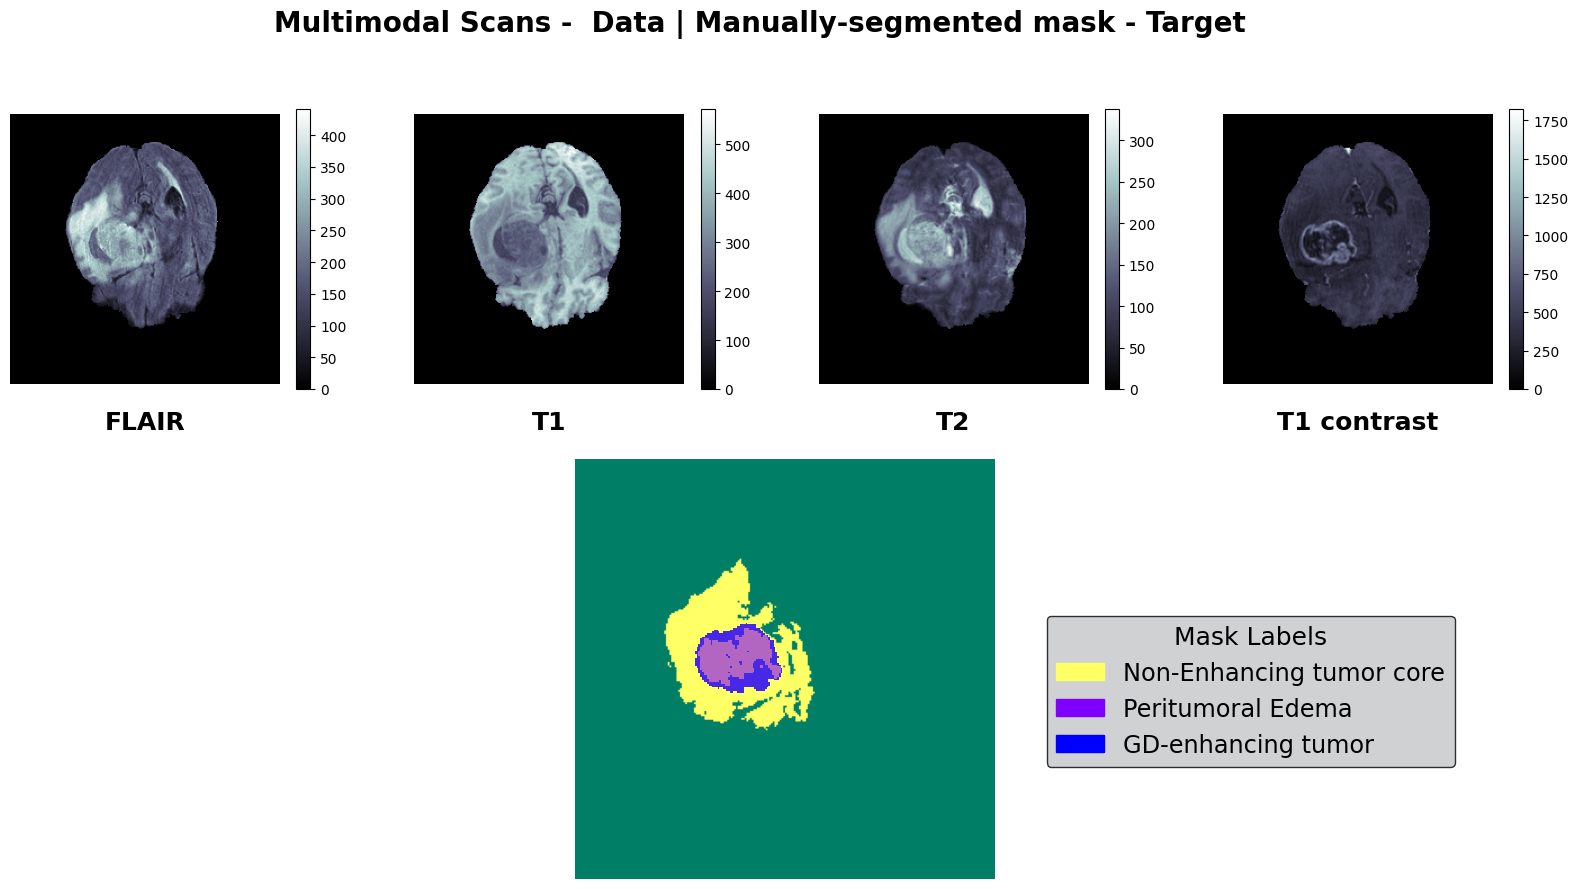

In [ ]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

helper classes and functions

In [ ]:
class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """
    def __init__(self, 
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z
    
    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    
    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean
    
    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)
            
        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)
        
        return resized_data
    
    def plot_cube(self,
                  cube,
                  title: str = '', 
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
        """
        Plot 3d data.
        Parameters:
            cube: 3d data
            title: title for figure.
            init_angle: angle for image plot (from 0-360).
            make_gif: if True create gif from every 5th frames from 3d image plot.
            path_to_save: path to save GIF file.
            """
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")
            
        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            # ax = fig.gca(projection='3d')
            ax = fig.add_subplot(111, projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                   
                    img = Image.open(fname)
                    img = img.resize((480, 480), Image.LANCZOS)
                    img.save(fname)
                   
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()

            else:
                plt.show()

                
class ShowResult:
  
    def mask_preprocessing(self, mask):
        """
        Test.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img
    
    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        
        fig, axes = plt.subplots(1, 2, figsize = (35, 30))
    
        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()
        
        plt.show()
        
#show_result = ShowResult()
#show_result.plot(data['image'], data['mask'], data['mask'])


# def merging_two_gif(path1: str, path2: str, name_to_save: str):
#     """
#     Merging GIFs side by side.
#     Parameters:
#         path1: path to gif with ground truth.
#         path2: path to gif with prediction.
#         name_to_save: name for saving new GIF.
#     """
#     #https://stackoverflow.com/questions/51517685/combine-several-gif-horizontally-python
#     #Create reader object for the gif
#     gif1 = imageio.get_reader(path1)
#     gif2 = imageio.get_reader(path2)

#     #If they don't have the same number of frame take the shorter
#     number_of_frames = min(gif1.get_length(), gif2.get_length()) 

#     #Create writer object
#     new_gif = imageio.get_writer(name_to_save)

#     for frame_number in range(number_of_frames):
#         img1 = gif1.get_next_data()
#         img2 = gif2.get_next_data()
#         #here is the magic
#         new_image = np.hstack((img1, img2))
#         new_gif.append_data(new_image)

#     gif1.close()
#     gif2.close()    
#     new_gif.close()

def combine_images_side_by_side(img1, img2):
    # Ensure both images have the same height
    if img1.shape[0] != img2.shape[0]:
        raise ValueError("Images do not have the same height.")
    
    # Concatenate images horizontally
    combined = np.concatenate((img1, img2), axis=1)
    return combined

def merging_two_gif(filename1, filename2, name_to_save):
    with imageio.get_reader(filename1) as gif1, imageio.get_reader(filename2) as gif2:
        frames_gif1 = gif1.get_length()
        frames_gif2 = gif2.get_length()
        number_of_frames = min(frames_gif1, frames_gif2)
        
        with imageio.get_writer(name_to_save, mode='I') as new_gif:
            for frame_number in range(number_of_frames):
                try:
                    img1 = gif1.get_data(frame_number)
                    img2 = gif2.get_data(frame_number)
                    # Example: Combine images side by side
                    combined = combine_images_side_by_side(img1, img2)
                    new_gif.append_data(combined)
                except EOFError:
                    print(f"Reached the end of one of the GIFs at frame {frame_number}.")
                    break

    
#merging_two_gif('BraTS20_Training_001_flair_3d.gif',
#                'BraTS20_Training_001_flair_3d.gif', 
#                'result.gif')

def get_all_csv_file(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path) 
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids


In [98]:
class GlobalConfig:
    root_dir = './'
    train_root_dir = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = './BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = './train_data.csv'
    pretrained_model_path = './last_epoch_model.pth'
    train_logs_path = './train_log.csv'
    ae_pretrained_model_path = './autoencoder_best_model.pth'
    tab_data = './df_with_voxel_stats_and_latent_features.csv'
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

Data Preprocessing

In [ ]:
survival_info_df = pd.read_csv('./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)
    
df['path'] = paths


train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)
train_data.to_csv("train_data.csv", index=False)

train_df -> (201, 12) val_df -> (34, 12) test_df -> (133, 10)


# Dataset DataLoader

In [100]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=True):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)
            
            if self.is_resize:
                img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)
            
            if self.is_resize:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                mask = np.clip(mask, 0, 1)
            mask = self.preprocess_mask_labels(mask)
    
            # augmented = self.augmentations(image=img.astype(np.float32), 
            #                                mask=mask.astype(np.float32))
            
            # img = augmented['image']
            # mask = augmented['mask']

            augmented = self.augmentations(image=img.astype(np.float32), 
                                       mask=mask.astype(np.float32))

            img = torch.from_numpy(augmented['image']).float()
            mask = torch.from_numpy(augmented['mask']).float()
    
        
            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }
        
        img = torch.from_numpy(img).float() #########
        
        return {
            "Id": id_,
            "image": img,
        }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

        

In [101]:
def get_augmentations(phase):
    list_transforms = []
    
    list_trfms = Compose(list_transforms, is_check_shapes=False)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 0,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        # num_workers=num_workers,
        num_workers=0,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader

In [102]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='./train_data.csv', phase='valid', fold=0, num_workers=0)
len(dataloader)


34

In [103]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

(['BraTS20_Training_162'],
 torch.Size([1, 4, 120, 120, 78]),
 torch.Size([1, 3, 120, 120, 78]))

Num uniq Image values : 209318
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([1109680,   13520]))


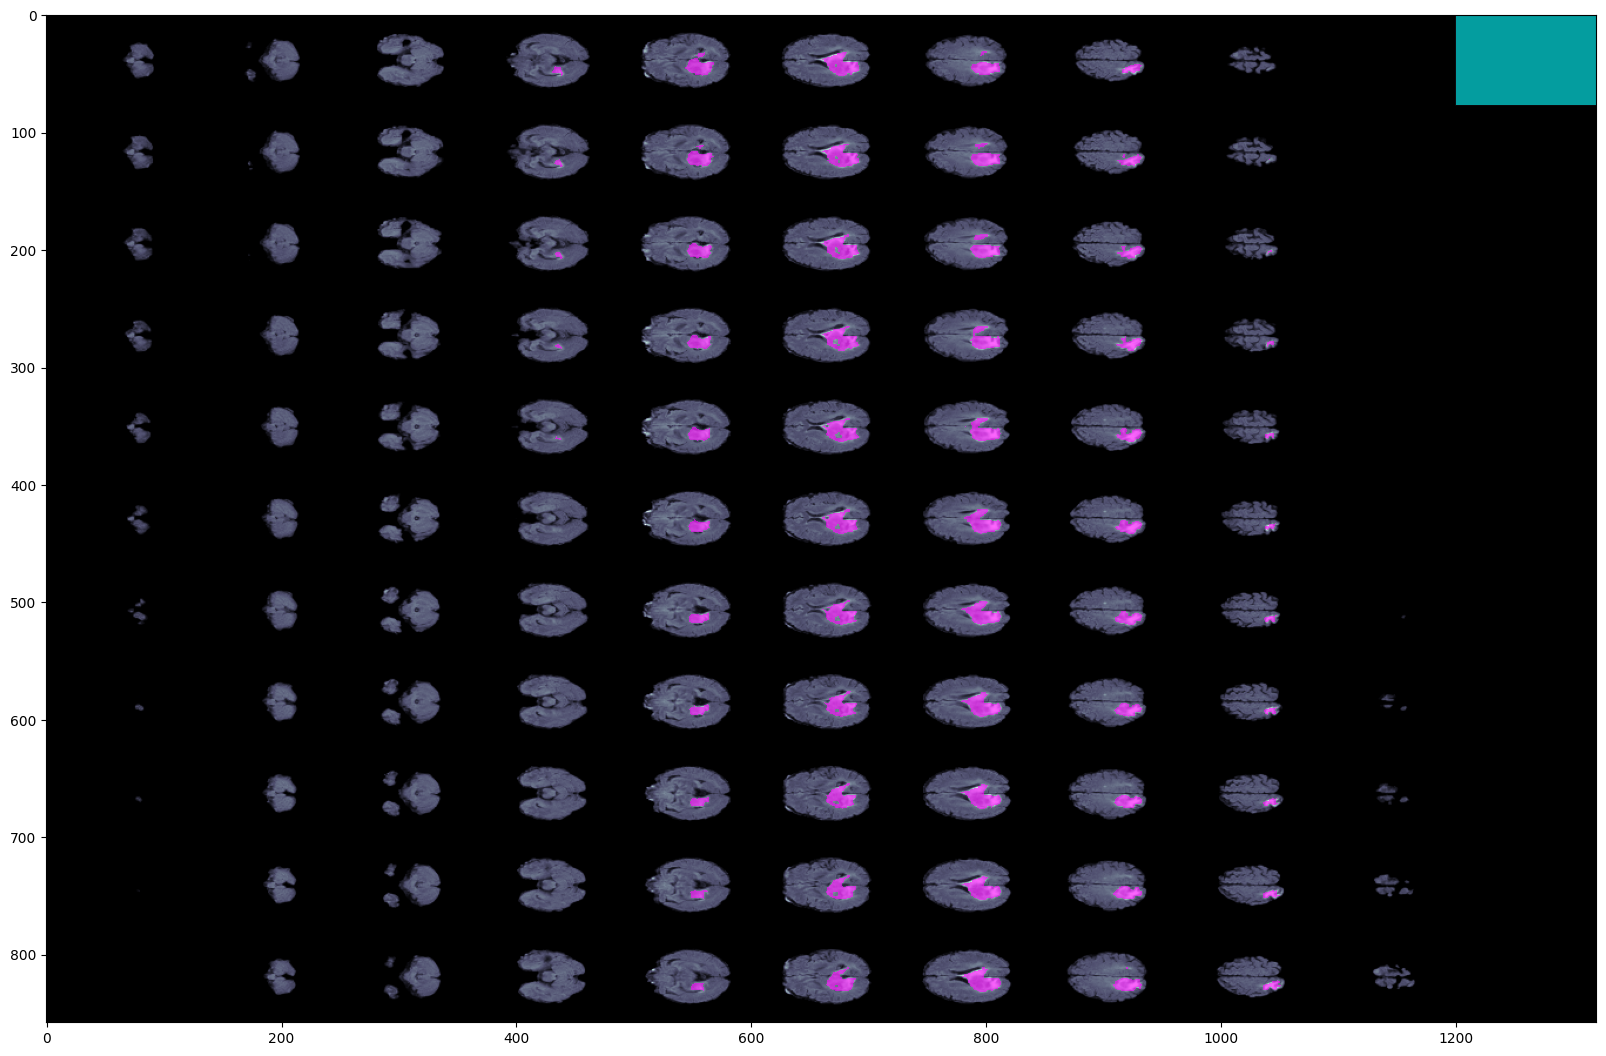

In [104]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

# Metric and Loss

In [105]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# 3DUnet

In [106]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

# Trainer

In [107]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 0
                
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-v0_8-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

training process

In [108]:
nodel = UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda')

In [109]:
trainer = Trainer(net=nodel,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=1,
                  path_to_csv = config.path_to_csv,)

if config.pretrained_model_path is not None:
    trainer.load_predtrain_model(config.pretrained_model_path)
    
    # if need - load the logs.      
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cuda
Predtrain model loaded


In [ ]:
%%time
trainer.run()

CPU times: total: 0 ns
Wall time: 0 ns


# Experiments and Results

In [111]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes


In [112]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0, num_workers=0)
len(dataloader)

34

In [113]:
nodel.eval()

UNet3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(4, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 24, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 24, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(24, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 48, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 48, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (enc2): Down(
   

In [114]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    nodel, val_dataloader, ['WT', 'TC', 'ET']
    )

CPU times: total: 11.8 s
Wall time: 38.2 s


In [115]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
4,0.846502,0.733857,0.845767,0.732752,1.0,1.0
9,0.915454,0.844089,0.917732,0.847970,1.0,1.0
27,0.942671,0.891558,0.945188,0.896072,1.0,1.0
2,0.766132,0.620919,0.769313,0.625109,1.0,1.0
20,0.843882,0.729927,0.843695,0.729648,1.0,1.0


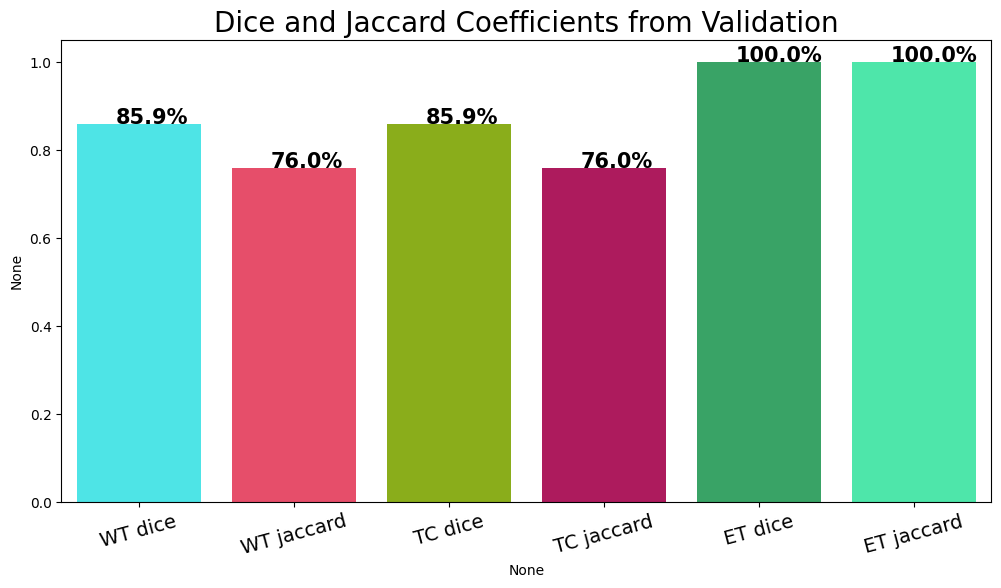

In [116]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

# 3DAutoEncoder

In [ ]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        features = 128  # Latent feature size 

        self.relu = nn.ReLU(inplace=True)

        self.dropout = nn.Dropout(p=0.2)

        # Encoder
        self.conv1 = nn.Conv3d(in_channels=4, out_channels=16, kernel_size=3, padding=0)
        self.gn1 = nn.GroupNorm(num_groups=4, num_channels=16) 

        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=0) 
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=32) 

        self.conv3 = nn.Conv3d(in_channels=32, out_channels=96, kernel_size=2, padding=0) 
        self.gn3 = nn.GroupNorm(num_groups=16, num_channels=96)

        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        
        self.enc_linear = nn.Linear(in_features=381216, out_features=features)
        self.gn_linear_enc = nn.GroupNorm(num_groups=1, num_channels=features) 
        self.enc_relu = nn.ReLU(inplace=True) 

        # regression head
        self.regressor = nn.Linear(in_features=features, out_features=1)

        # Decoder
        self.dec_linear = nn.Linear(in_features=features, out_features=381216)
        self.gn_linear_dec = nn.GroupNorm(num_groups=1, num_channels=381216)
        self.dec_relu = nn.ReLU(inplace=True) 

    
        self.deconv1 = nn.ConvTranspose3d(in_channels=192, out_channels=32, kernel_size=2, stride=1, padding=0) 
        self.gn_deconv1 = nn.GroupNorm(num_groups=8, num_channels=32) 

        self.deconv2 = nn.ConvTranspose3d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.gn_deconv2 = nn.GroupNorm(num_groups=4, num_channels=16) 

        self.deconv3 = nn.ConvTranspose3d(in_channels=32, out_channels=4, kernel_size=3, stride=1, padding=0)
        self.gn_deconv3 = nn.GroupNorm(num_groups=2, num_channels=4) 

        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        x = self.gn1(x)
        x = self.relu(x)
        out_conv1 = x.clone()  # save for skip
        up3out_shape = x.shape
        x, indices1 = self.pool1(x)

        x = self.conv2(x)
        x = self.gn2(x)
        x = self.relu(x)
        out_conv2 = x.clone()
        up2out_shape = x.shape
        x, indices2 = self.pool2(x)

        x = self.conv3(x)
        x = self.gn3(x)
        x = self.relu(x)
        out_conv3 = x.clone()  
        up1out_shape = x.shape
        x, indices3 = self.pool3(x)

        x = x.view((x.size(0), -1))  # flatten
        x = self.enc_linear(x)
        x = self.dropout(x)
        x = self.gn_linear_enc(x)
        x = self.enc_relu(x)
        
        pool_params = {
            "indices1": indices1, "output_shape1": up3out_shape,
            "indices2": indices2, "output_shape2": up2out_shape,
            "indices3": indices3, "output_shape3": up1out_shape
        }
        skip_connections = {
            "out_conv1": out_conv1,
            "out_conv2": out_conv2,
            "out_conv3": out_conv3
        }

        if return_partials:
            return x, pool_params, skip_connections
        else:
            return x

    def decode(self, x, pool_params, skip_connections):
        # Decoder
        x = self.dec_linear(x)
        x = self.gn_linear_dec(x)
        x = self.dec_relu(x)
        x = x.view((x.size(0), 96, 11, 19, 19)) 


        x = self.unpool1(x, indices=pool_params["indices3"], output_size=pool_params["output_shape3"])
        # concat skip connection from out_conv3
        x = torch.cat([x, skip_connections["out_conv3"]], dim=1) 

        x = self.deconv1(x)
        x = self.gn_deconv1(x)
        x = self.relu(x)

        x = self.unpool2(x, indices=pool_params["indices2"], output_size=pool_params["output_shape2"])
        x = torch.cat([x, skip_connections["out_conv2"]], dim=1)
        x = self.deconv2(x)
        x = self.gn_deconv2(x)
        x = self.relu(x)

        x = self.unpool3(x, indices=pool_params["indices1"], output_size=pool_params["output_shape1"])
        x = torch.cat([x, skip_connections["out_conv1"]], dim=1)
        x = self.deconv3(x)
        x = self.gn_deconv3(x)
        x = self.relu(x)

        return x

    def forward(self, x):
        latent_features, pool_params, skip_connections = self.encode(x)
        survival_pred = self.regressor(latent_features)
        reconstructed = self.decode(latent_features, pool_params, skip_connections)
        return reconstructed, survival_pred


### Dataset and Dataloader

In [127]:
def get_augmentations(phase):
    list_transforms = []
    
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 0,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [ ]:
class AutoEncoderDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = "test", survival_mean=None, survival_std=None):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.survival_mean = survival_mean
        self.survival_std = survival_std
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        id_ = self.df.loc[idx, 'Brats20ID']
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        # load all modalities
        images = []
        for data_type in self.data_types:
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)

            img = self.normalize(img)
            images.append(img.astype(np.float32))
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))


        # Add noise to images during training
        if self.phase == 'train':

            noise = np.random.normal(0, 0.2, img.shape).astype(np.float32)
            img_noisy = img + noise

            img_noisy = np.clip(img_noisy, 0., 1.)
        else:
            img_noisy = img

        ##add survival information
        survival_info_df = pd.read_csv('./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')

        survival_mean = survival_info_df['Survival_days'].mean()

        survival_std = survival_info_df['Survival_days'].std()


        survival_days = survival_info_df.loc[survival_info_df['Brats20ID'] == id_]['Survival_days'].values[0]
        survival_days = (survival_days - survival_mean) / survival_std
        survival_days = torch.tensor(survival_days).float()

        
        return {
            "Id": id_,
            "data": img_noisy,
            "label": img,
            "survival_days": survival_days,
            }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray,  mean=0.0, std=1.0):
        """Normilize image value between 0 and 1."""
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
        

In [129]:
survival_info_df = pd.read_csv('./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
survival_days = survival_info_df['Survival_days'].to_numpy()
dataloader = get_dataloader(AutoEncoderDataset, 'train_data.csv', phase='valid', fold=0, num_workers=0)
len(dataloader)

data = next(iter(dataloader))
data['Id'], data['data'].shape, data['label'].shape

(['BraTS20_Training_062'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 4, 155, 240, 240]))

### training process

In [ ]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 dataset: torch.utils.data.Dataset,
                 survival_mean: float,
                 survival_std: float):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.net = net.to(self.device)
        self.criterion = criterion  # For reconstruction loss
        self.survival_criterion = nn.MSELoss()  # For survival prediction loss
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.reconstruction_losses = {phase: [] for phase in self.phases}
        self.survival_losses = {phase: [] for phase in self.phases}

        self.dataloaders = {
            phase: get_dataloader(
                dataset=dataset,
                path_to_csv=path_to_csv,
                phase=phase,
                fold=fold,
                batch_size=batch_size,
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images, targets, survival_days):
        images = images.to(self.device)
        targets = targets.to(self.device)
        survival_days = survival_days.to(self.device)
        reconstructed, survival_pred = self.net(images)
        reconstruction_loss = self.criterion(reconstructed, targets)
        survival_loss = self.survival_criterion(survival_pred.squeeze(), survival_days)
        loss = reconstruction_loss + survival_loss ######### add weights to loss if necessary
        return loss, reconstruction_loss, survival_loss
    
    def _do_epoch(self, epoch, phase):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")
        self.net.train() if phase == "train" else self.net.eval()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        running_reconstruction_loss = 0.0
        running_survival_loss = 0.0
        self.optimizer.zero_grad()

        progress_bar = tqdm(dataloader, total=total_batches, desc=f"{phase} Epoch {epoch}") ##
        for itr, data_batch in enumerate(progress_bar):
            images, targets, survival_days = data_batch['data'], data_batch['label'], data_batch['survival_days']
            loss, reconstruction_loss, survival_loss = self._compute_loss_and_outputs(images, targets, survival_days)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            running_reconstruction_loss += reconstruction_loss.item()
            running_survival_loss += survival_loss.item()

            progress_bar.set_postfix({
                'Loss': loss.item(),
                'Reconstruction Loss': reconstruction_loss.item(),
                'Survival Loss': survival_loss.item()
            })
        
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_reconstruction_loss = (running_reconstruction_loss * self.accumulation_steps) / total_batches
        epoch_survival_loss = (running_survival_loss * self.accumulation_steps) / total_batches
        self.losses[phase].append(epoch_loss)
        self.reconstruction_losses[phase].append(epoch_reconstruction_loss)
        self.survival_losses[phase].append(epoch_survival_loss)
        print(f"Total Loss: {epoch_loss}")
        print(f"Reconstruction Loss: {epoch_reconstruction_loss}")
        print(f"Survival Loss: {epoch_survival_loss}")

        return epoch_loss
    
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "autoencoder_best_model.pth")
            print()
        self._save_train_history()
    
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")

    def _save_train_history(self):
        torch.save(self.net.state_dict(), "autoencoder_last_epoch_model.pth")


In [ ]:

survival_info_df = pd.read_csv('./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
survival_days = survival_info_df['Survival_days'].to_numpy()

model = AutoEncoder().to('cuda')

print(model)

# Update the trainer initialization
trainer = Trainer(
    net=model,
    dataset=AutoEncoderDataset,
    criterion=MSELoss(),
    lr=5e-4,
    accumulation_steps=4,
    batch_size=1,
    fold=0,
    num_epochs=3,
    path_to_csv=config.path_to_csv,
    survival_mean=survival_days.mean(),
    survival_std=survival_days.std()
)

# if config.ae_pretrained_model_path is not None:
#     trainer.load_predtrain_model(config.ae_pretrained_model_path)

RandomForestRegressor()


AttributeError: 'RandomForestRegressor' object has no attribute 'to'

In [ ]:
%%time
#torch.cuda.empty_cache()
trainer.run()

train epoch: 0 | time: 18:12:31


train Epoch 0:   0%|          | 0/201 [08:54<?, ?it/s, Loss=0.0706, Reconstruction Loss=0.281, Survival Loss=0.00137] 


Total Loss: 1.5995890333581326
Reconstruction Loss: 1.383854901316154
Survival Loss: 5.014501253218717
val epoch: 0 | time: 18:21:26


val Epoch 0:   0%|          | 0/34 [00:21<?, ?it/s, Loss=0.255, Reconstruction Loss=0.271, Survival Loss=0.747]   


Total Loss: 1.307282162063262
Reconstruction Loss: 1.1163631607504452
Survival Loss: 4.1127654911868055

####################
Saved new checkpoint
####################


train epoch: 1 | time: 18:21:49


train Epoch 1:   0%|          | 0/201 [09:25<?, ?it/s, Loss=0.213, Reconstruction Loss=0.0754, Survival Loss=0.776]    


Total Loss: 1.268131232194936
Reconstruction Loss: 0.8338379707947299
Survival Loss: 4.238686937112058
val epoch: 1 | time: 18:31:14


val Epoch 1:   0%|          | 0/34 [00:17<?, ?it/s, Loss=0.276, Reconstruction Loss=0.0637, Survival Loss=1.04]    


Total Loss: 1.0555880334885681
Reconstruction Loss: 0.3018707729437772
Survival Loss: 3.920481363530545

####################
Saved new checkpoint
####################


train epoch: 2 | time: 18:31:33


train Epoch 2:   0%|          | 0/201 [09:52<?, ?it/s, Loss=0.00563, Reconstruction Loss=0.00854, Survival Loss=0.014]  


Total Loss: 1.0836173397771531
Reconstruction Loss: 0.10222399025339986
Survival Loss: 4.2322453664151425
val epoch: 2 | time: 18:41:25


val Epoch 2:   0%|          | 0/34 [00:17<?, ?it/s, Loss=0.367, Reconstruction Loss=0.0217, Survival Loss=1.45]     


Total Loss: 0.948181760552175
Reconstruction Loss: 0.06984469283591299
Survival Loss: 3.7228823723956284

####################
Saved new checkpoint
####################


CPU times: total: 8min 13s
Wall time: 29min 11s


In [ ]:
torch.cuda.empty_cache()

Now let's generates all latent features

In [ ]:
class LatentFeaturesGenerator:
    def __init__(self, 
                 autoencoder, 
                 device: str = 'cuda'):
        
        self.autoencoder = autoencoder.to(device)
        self.device = device

    def __call__(self, img):
        with torch.no_grad():
            img = torch.FloatTensor(img).unsqueeze(0).to(self.device)
            # Extract only the latent features
            latent_features = self.autoencoder.encode(img, return_partials=False)
            latent_features = latent_features.squeeze(0).cpu().numpy()
            
        return latent_features

In [ ]:
class Features_Generator:
    
    def __init__(self, df, autoencoder):
        self.df = df
        self.df_voxel_stats = pd.DataFrame()
        self.latent_feature_generator = LatentFeaturesGenerator(autoencoder)
        
    def _read_file(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj).astype(np.float32)
        return data
    
    def _normalize(self, data: np.ndarray):
        """Normilize image value between 0 and 1."""
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def _create_features(self, Brats20ID):
        features = {}
        images = []
        # vOXEL STATS
        for data_type in ['_t1.nii', '_t2.nii', '_flair.nii', '_t1ce.nii']:
            
            
            # data path
            root_path = self.df.loc[self.df['Brats20ID'] == Brats20ID]['path'].values[0]
            file_path = os.path.join(root_path, Brats20ID + data_type)
            
            # flatten 3d array
            img_data = self._read_file(file_path)
            data = img_data.reshape(-1)
            
            # create features
            data_mean = data.mean()
            data_std = data.std()
            intensive_data = data[data > data_mean]
            more_intensive_data = data[data > data_mean + data_std]
            non_intensive_data = data[data < data_mean]
            
            data_skew = stats.skew(data)
            data_kurtosis = stats.kurtosis(data)
            intensive_skew = stats.skew(intensive_data)
            non_intensive_skew = stats.skew(non_intensive_data)
            
            data_diff = np.diff(data)
            
            # write new features in df
            features['Brats20ID'] = Brats20ID
            features[f'{data_type}_skew'] = data_skew,
            features[f'{data_type}_kurtosis'] = data_kurtosis,
            features[f'{data_type}_diff_skew'] = stats.skew(data_diff),
            features[f'{data_type}_intensive_dist'] = intensive_data.shape[0],
            features[f'{data_type}_intensive_skew'] = intensive_skew,
            features[f'{data_type}_non_intensive_dist'] = non_intensive_data.shape[0],
            features[f'{data_type}_non_intensive_skew'] = non_intensive_skew,
            #features[f'{data_type}_intensive_non_intensive_mean_ratio'] = intensive_data.mean() / non_intensive_data.mean(),
            #features[f'{data_type}_intensive_non_intensive_std_ratio'] = intensive_data.std() / non_intensive_data.std(),
            features[f'{data_type}_data_intensive_skew_difference'] = data_skew - intensive_skew,
            features[f'{data_type}_data_non_intensive_skew_difference'] = data_skew - non_intensive_skew,
            features[f'{data_type}_more_intensive_dist'] = more_intensive_data.shape[0],
            
            parts = 15
            for p, part in enumerate(np.array_split(data, parts)):
                features[f'{data_type}_part{p}_mean'] = part.mean()
                
            # Latent Features    
            img = self._normalize(img_data)
            images.append(img.astype(np.float32))
            
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        latent_features = self.latent_feature_generator(img)
        
        for i, lf in enumerate(latent_features):
                features[f'latent_f{i}'] = lf
          
        return pd.DataFrame(features)
    
    
    def run(self):
        
        for _, row in tqdm(self.df.iterrows(), total=self.df.shape[0]):
            ID = row['Brats20ID']
            
            df_features = self._create_features(ID)
            
            self.df_voxel_stats  = pd.concat([self.df_voxel_stats, df_features], axis=0) 
            
        self.df_voxel_stats.reset_index(inplace=True, drop=True) 
        self.df_voxel_stats = self.df_voxel_stats.merge(self.df[['Brats20ID', 'Age', 'Survival_days']], on='Brats20ID', how='left')
            

In [ ]:
%%time
model.eval()
fg = Features_Generator(df, model)
fg.run()
fg.df_voxel_stats.to_csv("voxel_stats_and_latent_features.csv", index=False)
fg.df_voxel_stats

100%|██████████| 369/369 [15:48<00:00,  2.57s/it]

CPU times: total: 5min 12s
Wall time: 15min 48s


,Brats20ID,_t1.nii_skew,_t1.nii_kurtosis,_t1.nii_diff_skew,_t1.nii_intensive_dist,_t1.nii_intensive_skew,_t1.nii_non_intensive_dist,_t1.nii_non_intensive_skew,_t1.nii_data_intensive_skew_difference,_t1.nii_data_non_intensive_skew_difference,...,latent_f120,latent_f121,latent_f122,latent_f123,latent_f124,latent_f125,latent_f126,latent_f127,Age,Survival_days
0,BraTS20_Training_001,2.189105,3.143948,-0.302683,1342282,-0.410911,7585718,114.730576,2.600016,-112.541471,...,1.471087,0.0,1.562477,0.0,0.0,0.0,0.0,2.526593,60.463,289.0
1,BraTS20_Training_002,1.968389,2.200515,0.225981,1538803,-0.403005,7389197,143.749908,2.371394,-141.781520,...,1.470448,0.0,1.558715,0.0,0.0,0.0,0.0,2.525076,52.263,616.0
2,BraTS20_Training_003,2.297638,3.615512,1.908453,1261059,-0.654111,7666941,357.393250,2.951749,-355.095611,...,1.474943,0.0,1.561170,0.0,0.0,0.0,0.0,2.531516,54.301,464.0
3,BraTS20_Training_004,1.953941,2.127259,0.014855,1523029,-0.297262,7404971,292.762421,2.251202,-290.808480,...,1.470785,0.0,1.558300,0.0,0.0,0.0,0.0,2.526327,39.068,788.0
4,BraTS20_Training_005,2.105768,2.791831,1.007016,1441603,-0.469777,7486397,192.826630,2.575545,-190.720862,...,1.472711,0.0,1.561068,0.0,0.0,0.0,0.0,2.529315,68.493,465.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,BraTS20_Training_365,2.232847,3.353795,2.639713,1302376,-0.186473,7625624,NaN,2.419320,NaN,...,1.474539,0.0,1.557867,0.0,0.0,0.0,0.0,2.530203,NaN,NaN
365,BraTS20_Training_366,2.503319,4.466537,-2.969314,1054761,-1.161960,7873239,1984.091309,3.665279,-1981.587990,...,1.478386,0.0,1.552718,0.0,0.0,0.0,0.0,2.532430,72.000,633.0
366,BraTS20_Training_367,1.795406,1.509976,0.253106,1696109,-0.426782,7231891,1903.602173,2.222188,-1901.806767,...,1.474902,0.0,1.554792,0.0,0.0,0.0,0.0,2.531520,60.000,437.0
367,BraTS20_Training_368,2.150280,2.922769,3.318562,1364050,-0.701649,7563950,192.933716,2.851929,-190.783436,...,1.473492,0.0,1.561220,0.0,0.0,0.0,0.0,2.528407,49.000,442.0


In [ ]:
torch.cuda.empty_cache()

Now that we have tabular data, we can use it to predict age and survival days.
we will use SVR for this purpose.

In [ ]:
df = pd.read_csv("voxel_stats_and_latent_features.csv")#

df['is_train'] = 0
df['is_train'].loc[df['Survival_days'].notnull()] = 1

# df['SD'] = df['Survival_days'].str.extract(r'(\d+[.\d]*)')
df["Survival_days"] = pd.to_numeric(df["Survival_days"], errors='coerce')
df = df.dropna(subset=["Survival_days"])

df['SD'] = df['Survival_days'].astype("float64")
df['Age'] = df['Age'].astype("float64")
df.drop(columns=['Survival_days'], inplace=True)

#replace NaN with 0 in voxel feature columns
exclude_cols = ['Age', 'SD']
cols_to_fill = df.columns.difference(exclude_cols)
df[cols_to_fill] = df[cols_to_fill].fillna(0)
df.sample(5)

,Brats20ID,_t1.nii_skew,_t1.nii_kurtosis,_t1.nii_diff_skew,_t1.nii_intensive_dist,_t1.nii_intensive_skew,_t1.nii_non_intensive_dist,_t1.nii_non_intensive_skew,_t1.nii_data_intensive_skew_difference,_t1.nii_data_non_intensive_skew_difference,...,latent_f121,latent_f122,latent_f123,latent_f124,latent_f125,latent_f126,latent_f127,Age,is_train,SD
222,BraTS20_Training_223,1.919593,1.937144,0.871874,1504721,-0.871498,7423279,38.062210,2.791092,-36.142617,...,0.0,1.563452,0.0,0.0,0.0,0.0,2.529785,48.825,1,1282.0
43,BraTS20_Training_044,1.979394,2.217036,-0.239583,1502516,-0.443115,7425484,173.595657,2.422509,-171.616263,...,0.0,1.561287,0.0,0.0,0.0,0.0,2.529866,54.825,1,871.0
273,BraTS20_Training_274,2.106754,2.731147,-4.458778,1336407,0.031885,7591593,116.655312,2.074868,-114.548558,...,0.0,1.563306,0.0,0.0,0.0,0.0,2.532206,NaN,0,NaN
55,BraTS20_Training_056,2.460512,4.470874,0.203145,1172665,-0.492668,7755335,1970.636719,2.953180,-1968.176207,...,0.0,1.561461,0.0,0.0,0.0,0.0,2.531250,71.126,1,208.0
328,BraTS20_Training_329,1.969474,2.114282,-2.012166,1493486,-0.984213,7434514,36.881779,2.953686,-34.912305,...,0.0,1.557439,0.0,0.0,0.0,0.0,2.524782,NaN,0,NaN


In [ ]:
test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()
print("train ->", df.shape, "test ->", test_df.shape)

train -> (236, 232) test -> (133, 232)


# Train Neural Network to Predict Survival Days

In [ ]:

df = df.dropna()  
X = df.drop(columns=['Survival_days']) 
X = X.select_dtypes(include=[np.number]) 
# Drop columns with all zero values
X = X.loc[:, (X != 0).any(axis=0)]
y = df['Survival_days']


# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components = 80)
X_pca = pca.fit_transform(X_scaled)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train and Test Linear Regression
linear_reg_pca = LinearRegression()
linear_reg_pca.fit(X_train_pca, y_train_pca)

# Get Predictions from Linear Regression for the Test Set=
y_pred_lr_pca = linear_reg_pca.predict(X_test_pca)

model_pca = Sequential()
print(X_train_pca.shape[1])

# neural network
model_pca.add(Dense(512, input_dim=X_train_pca.shape[1], activation='relu'))
model_pca.add(BatchNormalization())
model_pca.add(Dropout(0.3))

model_pca.add(Dense(256, activation='relu'))
model_pca.add(BatchNormalization()) 
model_pca.add(Dropout(0.3))  

model_pca.add(Dense(128, activation='relu'))
model_pca.add(BatchNormalization())
model_pca.add(Dropout(0.2))

model_pca.add(Dense(64, activation='relu'))

# Output Layer
model_pca.add(Dense(1))

model_pca.compile(optimizer='adam', loss='mean_squared_error')

# Train nn
history_pca = model_pca.fit(X_train_pca, y_train_pca,
                            epochs=100,
                            batch_size=32,
                            validation_data=(X_test_pca, y_test_pca),
                            verbose=1)

y_pred_nn_pca = model_pca.predict(X_test_pca).flatten()

def custom_score(y_true, y_pred):
    """
    Custom scoring function
    """
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0) / np.sum(y_true, axis=0))

test_score_lr_pca = custom_score(y_test_pca, y_pred_lr_pca)
print(f"Test Score for Linear Regression (with PCA): {np.round(test_score_lr_pca, 4)}")

test_score_nn_pca = custom_score(y_test_pca, y_pred_nn_pca)
print(f"Test Score for Neural Network (with PCA): {np.round(test_score_nn_pca, 4)}")

plt.figure(figsize=(10, 6))
plt.plot(history_pca.history['loss'], label='Training Loss')
plt.plot(history_pca.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss Across Epochs (with PCA)')
plt.legend()
plt.grid(True)
plt.show()